# Project - Twitter Trades

Group: Individual (Ying Chan)

# Abstract

In this paper, we will leverage tweets in Twitter related to individual stocks to analyze what factors attribute to each individual stock's movements (both up and down). With these factors, along with Natural Language Proessing, we build an algorithm that can potentially flag potential up and down movements based on new tweets, and invest/capture this. We implement a few naive portfolio management strategies including long-short portfolio strategies, or long only strategies and compare the returns. We also use accuracy metrics to determine whether the prediction is correct for each time interval. 

# Introduction

Stock market prediction has been around for a long period of time. However, most literature attempts to predict the actual returns of the stock, however, we believe that there is too much information and noise for the model to correctly predict a return, for example Stock Prediction Using Twitter Sentiment Analysis by Anshul Mittal/Arpit Goel[1]. However, we believe tweets can be used to predict a movement in the upward or downward direction. We use the direction as up and down as proxies of "sentiment" and use the model to predict whether the stock would most likely trend up or down in a set time frame. In this paper, we will look at short time intervals of 5 minutes. 


# Data Sources

We will obtain stock price data obtained at 5-minute intervals from Stooq.com. We will be looking at the S&P500 stocks, and will observe the open and close for each time interval to determine the return. 

For the tweets, we will be leveraging the Twitter API, filtered by the stock symbol. The time frame will be as far back as possible. However there are limitations of the use of the Twitter API. Although we have developed code to append and collect Twitter data, time constraints and the limited use of the API poses problems in the short time frame of an assignment which involves designing/testing. Regardless, we managed to collect some data and produce meaningful results.

With the twitter data, we join this with the 5 minute interval return data computed from the stock price data for each of the stocks in the S&P500. Using the direction of the return, we are able to assign each tweet a sentiment, namely up or down. We believe further granularity of the sentiment will pose noise in the model, and we believe up and down movements is sufficient to produce a meaningful portfolio strategy. 



# Model

Start with loading all stocks in the S&P 500 into a dataframe. 

In [136]:
snp500 = pd.read_csv('snp500.csv', header=0)
print snp500[:5]

  Ticker symbol             Security             GICS Sector  \
0           MMM           3M Company             Industrials   
1           ABT  Abbott Laboratories             Health Care   
2          ABBV               AbbVie             Health Care   
3           ACN        Accenture plc  Information Technology   
4          ATVI  Activision Blizzard  Information Technology   

                GICS Sub Industry  
0        Industrial Conglomerates  
1           Health Care Equipment  
2                 Pharmaceuticals  
3  IT Consulting & Other Services  
4     Home Entertainment Software  


Load Tweepy library and start collecting search terms based on stocks in the S&P500. We start with a specific stock $RDUS for testing purposes of the algorithm. 

In [13]:
import tweepy
import csv
import pandas as pd

consumer_key="LX38iNoplbbMid20arGtsivQh"
consumer_secret="w1KQHobzm77FFdVMHIzHJJPPaPrHdx53e2Dq8CnuOwh0yr7luD"

access_token="268119650-HPK3lM3WSCnDAvl8d7PDmxwcWcRDC1XUZYr77doh"
access_token_secret="tu4UNdMdCWh0E7AuduS3EI2xliPSUv1TXTqPCj3NuglFb"

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)

api = tweepy.API(auth)

For each stock in the S&P500 (we will limit to 100 first due to the Twitter API not allowing for more than a few hundred API calls per hour), we will search the Twitter API for tweets that are filtered by a "$" followed by the ticker symbol. The results are stored into a CSV file.

In [29]:
for i in range(0,100):
    ticker = snp500.loc[snp500.index[i], 'Ticker symbol']
    search_ticker = "$" + ticker
    csv_ticker = ticker + ".csv"
    
    #find the latest date for the last tweet stored for each stock
    #tweet_latest_date = pd.read_csv(csv_ticker, header=None)
    #date = pd.to_datetime(tweet_latest_date.tail(1)[0]).iloc[0]
    
    #query twitter api to obtain tweet results
    results = api.search(q=search_ticker, count=10000 , include_entities=True, lang="en", since_id=2016-11-11)

    #write to csv file and append new tweets
    with open(csv_ticker, 'wb') as csvfile:
        writer = csv.writer(csvfile)
        for result in results:
            writer.writerow([result.created_at, unicode(result.text).encode("utf-8") ])

In [64]:
#split into multiple loops to get around "Rate Limit Exceeded" error message on twitter api. Rerun after 1 hour.
for i in range(100, 200):
    ticker = snp500.loc[snp500.index[i], 'Ticker symbol']
    search_ticker = "$" + ticker
    csv_ticker = ticker + ".csv"
    
    #find the latest date for the last tweet stored for each stock
    #tweet_latest_date = pd.read_csv(csv_ticker, header=None)
    #date = pd.to_datetime(tweet_latest_date.tail(1)[0]).iloc[0]
    
    #query twitter api to obtain tweet results
    results = api.search(q=search_ticker, count=1000 , include_entities=True, lang="en", since_id=2016-11-11)

    #write to csv file and append new tweets
    with open(csv_ticker, 'wb') as csvfile:
        writer = csv.writer(csvfile)
        for result in results:
            writer.writerow([result.created_at, unicode(result.text).encode("utf-8") ])

In [75]:
for i in range(200, 300):
    ticker = snp500.loc[snp500.index[i], 'Ticker symbol']
    search_ticker = "$" + ticker
    csv_ticker = ticker + ".csv"
    
    #find the latest date for the last tweet stored for each stock
    #tweet_latest_date = pd.read_csv(csv_ticker, header=None)
    #date = pd.to_datetime(tweet_latest_date.tail(1)[0]).iloc[0]
    
    #query twitter api to obtain tweet results
    results = api.search(q=search_ticker, count=1000 , include_entities=True, lang="en", since_id=2016-11-11)

    #write to csv file and append new tweets
    with open(csv_ticker, 'wb') as csvfile:
        writer = csv.writer(csvfile)
        for result in results:
            writer.writerow([result.created_at, unicode(result.text).encode("utf-8") ])

In [101]:
for i in range(300, 400):
    ticker = snp500.loc[snp500.index[i], 'Ticker symbol']
    search_ticker = "$" + ticker
    csv_ticker = ticker + ".csv"
    
    #find the latest date for the last tweet stored for each stock
    #tweet_latest_date = pd.read_csv(csv_ticker, header=None)
    #date = pd.to_datetime(tweet_latest_date.tail(1)[0]).iloc[0]
    
    #query twitter api to obtain tweet results
    results = api.search(q=search_ticker, count=1000 , include_entities=True, lang="en", since_id=2016-11-11)

    #write to csv file and append new tweets
    with open(csv_ticker, 'wb') as csvfile:
        writer = csv.writer(csvfile)
        for result in results:
            writer.writerow([result.created_at, unicode(result.text).encode("utf-8") ])

In [ ]:
for i in range(400, 500):
    ticker = snp500.loc[snp500.index[i], 'Ticker symbol']
    search_ticker = "$" + ticker
    csv_ticker = ticker + ".csv"
    
    #find the latest date for the last tweet stored for each stock
    #tweet_latest_date = pd.read_csv(csv_ticker, header=None)
    #date = pd.to_datetime(tweet_latest_date.tail(1)[0]).iloc[0]
    
    #query twitter api to obtain tweet results
    results = api.search(q=search_ticker, count=1000 , include_entities=True, lang="en", since_id=2016-11-11)

    #write to csv file and append new tweets
    with open(csv_ticker, 'wb') as csvfile:
        writer = csv.writer(csvfile)
        for result in results:
            writer.writerow([result.created_at, unicode(result.text).encode("utf-8") ])

We create a process tweet function to make all the words lower case and convert any hastags into normal words. This will help with pre-processing the tweet and improving the NLP model.

In [ ]:
import re

#Perform basic pre-processing of tweet to improve our NLP model
def preprocess_tweet(tweet):
    #Lower case all words
    tweet = tweet.lower()
    #Remove URL strings
    tweet = re.sub('((www\.[^\s]+)|(https?://[^\s]+))','URL',tweet)
    #Remove double spacing
    tweet = re.sub('[\s]+', ' ', tweet)
    #Remove usernames
    tweet = re.sub('@[^\s]+','TWITTER_USER_NAME',tweet)
    #Remove hashtags
    tweet = re.sub(r'#([^\s]+)', r'\1', tweet)
    tweet = tweet.strip('\'"')
    #strip punctuation
    return tweet

Read CSV data from tweets and stocks to merge and append to dataframe. We also create a function to find the closest date and apply to existing panda dataframes to join the tweets data to the stock data. We keep the tweets data as the left dataframe as this is the data that is of interest. If there is no tweet, there is no need to observe stock data. We attempt to fit a traditional Gaussian Naive Bayes prediction model based on the occurence of words within the tweet to start, but will do so with individual models. We use the metric of accuracy (i.e. how many % the test data does the direction of the stock in the next 5 minute get predicted correctly) to assess the model for starter. 

In [226]:
import pandas as pd
import numpy as np

import re, nltk
from sklearn.feature_extraction.text import CountVectorizer        
from nltk.stem.porter import PorterStemmer
from sklearn.naive_bayes import GaussianNB
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score

def find_closest_date(timepoint, time_series, add_time_delta_column=True):
    deltas = np.abs(time_series - timepoint)
    idx_closest_date = np.argmin(deltas)
    res = {"closest_date": time_series.ix[idx_closest_date]}
    idx = ['closest_date']
    if add_time_delta_column:
        res["closest_delta"] = deltas[idx_closest_date]
        idx.append('closest_delta')
    return pd.Series(res, index=idx)

#Create functions for tokenize and stemming and the count vectorizer
stemmer = PorterStemmer()
def stem_tokens(tokens, stemmer):
    stemmed = []
    for item in tokens:
        stemmed.append(stemmer.stem(item))
    return stemmed

def tokenize(text):
    text = re.sub("[^a-zA-Z]", " ", text)
    tokens = nltk.word_tokenize(text)
    stems = stem_tokens(tokens, stemmer)
    return stems

vectorizer = CountVectorizer(
    analyzer = 'word',
    tokenizer = tokenize,
    lowercase = True,
    stop_words = 'english',
    max_features = 85
)

import nltk.data
tokenizer = nltk.data.load('nltk:tokenizers/punkt/english.pickle')

indep_model_accuracy = []
indep_model_return = []
indep_model_ls_return = []

for i in range(0,300):
    ticker = snp500.loc[snp500.index[i], 'Ticker symbol']
    tweet_csv = ticker +'.csv'
    stock_csv = ticker +'.us.txt'
    tweets = pd.read_csv(tweet_csv, header=None)
    stocks = pd.read_csv(stock_csv)
    tweets.columns = ['timestamp', 'tweet']

    stocks['Timestamp'] = stocks.Date.astype(str).str.cat(stocks.Time.astype(str), sep=' ')

    #Convert to pandas date time format
    stocks['Timestamp'] = pd.to_datetime(stocks['Timestamp']) 
    tweets['timestamp'] = pd.to_datetime(tweets['timestamp']) 

    stocks['PreviousClose'] = stocks.Close.shift(1)
    stocks['Return'] = (stocks.Close/stocks.PreviousClose)-1
    
    tweets[['closest_timestamp', 'diff']] = tweets.timestamp.apply(
                                          find_closest_date, args=[stocks.Timestamp])

    combined = pd.merge(tweets, stocks, left_on=['closest_timestamp'], right_on=['Timestamp'])
    combined['Prediction_Class'] = np.where(combined['Return']>0, 'Up', 'Down')
    corpus_data_features = vectorizer.fit_transform(combined.tweet.tolist())
    corpus_data_features_nd = corpus_data_features.toarray()
    
    #Break out of loop if the stock does not have historical tweets. This will be flagged based on if the close price
    #is exactly the same as the last close price on the last tweet.
    if combined.Close.iloc[0]==combined.Close.iloc[len(combined)-1]:
        continue
    
    X_train, X_test, y_train, y_test  = train_test_split(
        corpus_data_features_nd[0:len(combined)], 
        combined.Prediction_Class,
        train_size=0.85)

    gnb_model = GaussianNB()
    gnb_model = gnb_model.fit(X=X_train, y=y_train)
    
    y_test_final = pd.Series.tolist(y_test)
    y_pred = gnb_model.predict(X_test)
    accuracy = accuracy_score(y_test_final, y_pred)
    
    agg_return = combined.Return[y_test.index]
    agg = pd.Series.tolist(agg_return)
    
    #Compute the actual stock return (regardless of time period) on a long only basis. i.e. we only capture return
    #if the stock is predicted to go up, and we assume an all-in all-out scenario, meaning positive returns are 
    #cumulative.
    stock_return = 1
    for i in (0, len(y_pred)-1):
        if y_pred[i] == "Up":
            stock_return = stock_return * (1 + agg[i])
    
    ls_stock_return = 1
    for i in (0, len(y_pred)-1):
        if y_pred[i] == "Up":
            ls_stock_return = ls_stock_return * (1 + agg[i])
        if y_pred[i] == "Down":
            ls_stock_return = ls_stock_return * (1 - agg[i])
            
            
    indep_model_return.append(stock_return)
    indep_model_ls_return.append(ls_stock_return)
    
    indep_model_accuracy.append(accuracy)
    #print "Ticker: %s, Accuracy: %f" % (ticker, accuracy)


Helper function created below to observe the occurence of words in the tweet that is stored in the corpus_data_features_nd array for each of the stocks. Below shows an example of the last run stock and the feature vector that is used for the model. 

In [227]:
vocab = vectorizer.get_feature_names()
dist = np.sum(corpus_data_features_nd, axis=0)
for tag, count in zip(vocab, dist):
    print count, tag

4 agn
6 amp
3 asset
6 b
3 bancorp
8 bank
6 bax
6 blk
3 boost
5 bought
4 breakdown
2 bullish
2 chartseer
2 child
2 china
6 cma
3 corp
5 cut
6 d
5 earn
3 exxonmobil
7 g
3 gcejz
3 gi
5 group
6 gt
15 ha
4 high
61 http
2 increas
2 intern
3 invest
2 jdnxh
31 johnson
2 k
3 kbc
3 khc
6 liquid
4 llc
6 long
3 maa
5 manag
3 mdt
31 mead
3 mellon
64 mjn
3 n
3 new
3 novemb
2 nsrgi
30 nutrit
3 nv
8 p
3 pfe
3 pm
2 polici
16 posit
3 ppl
6 profit
5 pznskpuhru
6 r
4 ratio
5 rt
11 s
2 sale
4 setup
8 share
15 short
2 shouldn
4 sold
7 stake
8 stock
63 t
3 technic
6 trade
3 tsn
3 tx
3 viab
5 w
2 wa
3 wolfofweedst
3 yhoo
3 york
3 zc
3 ztvz


# Evaluation of Model

The evaluation technique for this type of model would be to see if certain tweets will be able to predict future moves that are significant and produce a portfolio management strategy. For example, if a tweet relating to "drug price" against this stock (or even other stocks) that causes the model to predict a movement does indeed predict a movement. The magnitude of movement is not an important measure here, though the direction is important. Another metric that can be measured will be a model portfolio performance using this algorithm, whether it will "beat" a traditional risk free rate return.

Plot histogram of the accuracy for each of the 500 stocks in S&P 500. Given the limitation of the Twitter API limiting the number of returns, we will not be able to asssess stocks that returns tweets only in the past few days (especially during weekends), as the stock price does not move. This resulted in stocks being predicted to go "Up", as our definiton of a stock price going up includes a flatline move. We plot this result in a histogram to see our assessment. 

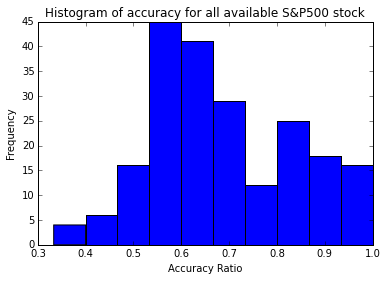

In [228]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.hist(indep_model_accuracy)
plt.title("Histogram of accuracy for all available S&P500 stock")
plt.xlabel("Accuracy Ratio")
plt.ylabel("Frequency")
plt.show()

Although this provides one metric of accuracy, we also want to see the magnitude of each of the predictions although the model is not required to predict this. We will match the return for each of the accurate predictions, and provide the opposite return metric for the wrong prediction. We will first go with a long only strategy (which means if the model predicts an up move, we will go all in onto the strategy and produce a long on the stock for 5 minutes). The stock will then be exited until the next "Up" prediction where all the proceeds are re-invested.

Below shows a histogram of the returns for the stocks in question above.

0.47641509434


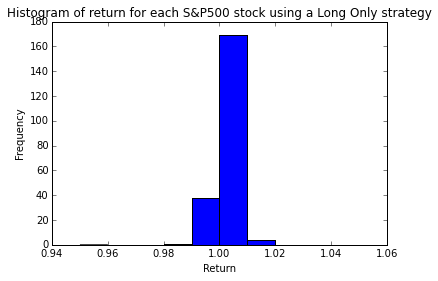

In [229]:
#count how many of the returns are actually larger than 1.00 over the time period and divide by length of vector
print sum(i > 1.0 for i in indep_model_return)*1.0/len(indep_model_return)

%matplotlib inline
import matplotlib.pyplot as plt
plt.hist(indep_model_return, bins=[0.95, 0.96, 0.97, 0.98, 0.99, 1.00, 1.01, 1.02, 1.03, 1.04, 1.05])
plt.title("Histogram of return for each S&P500 stock using a Long Only strategy")
plt.xlabel("Return")
plt.ylabel("Frequency")
plt.show()

Note that there is significant concentration around the 1.000 return range, i.e. meaning that there is no return. However, we need to keep in mind that we are looking at 5 minute interval data, and only within the test sample (15%) of any tweet. Given the fundamental difficulties in portfolio management to generate returns, our result above is not surprising. 

We try this same model with a long-short strategy. A long short strategy would be if the prediction is a downward move, then we will short the selected stock for 5 minutes and then exit the position (i.e. close the short position) and capture the downward movement. If the prediction is an upward move, we will long the selected stock for 5 minutes and then exist the position by selling. This does not take into account of borrowing costs which we believe to be immaterial for our purposes. 

Our above model looks at a strategy that longs or shorts one stock at a time. Let us extend this concept into a more traditonal portfolio management paradigm and look at whether we can trade in and out of various stocks that flash a bigger buy signal or a bigger sell signal. 

0.617924528302


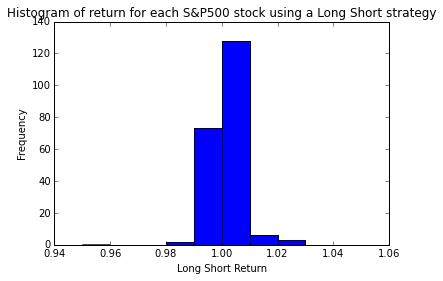

In [231]:
#count how many of the returns are actually larger than 1.00 over the time period and divide by length of vector
print sum(i > 1.0 for i in indep_model_ls_return)*1.0/len(indep_model_ls_return)

%matplotlib inline
import matplotlib.pyplot as plt
plt.hist(indep_model_ls_return, bins=[0.95, 0.96, 0.97, 0.98, 0.99, 1.00, 1.01, 1.02, 1.03, 1.04, 1.05])
plt.title("Histogram of return for each S&P500 stock using a Long Short strategy")
plt.xlabel("Long Short Return")
plt.ylabel("Frequency")
plt.show()

# TFIDF and Other Models

We will explore using other vectorizers for language processing models as well as other machine learning models to evaluate performance. We will not show all the various possibilities here, but will show an example below and summarize a few of the basic metrics for comparison in the conclusion section of this paper. 

In [232]:
import pandas as pd
import numpy as np

import re, nltk
from sklearn.feature_extraction.text import TfidfVectorizer        
from nltk.stem.porter import PorterStemmer
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier

from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score

def find_closest_date(timepoint, time_series, add_time_delta_column=True):
    deltas = np.abs(time_series - timepoint)
    idx_closest_date = np.argmin(deltas)
    res = {"closest_date": time_series.ix[idx_closest_date]}
    idx = ['closest_date']
    if add_time_delta_column:
        res["closest_delta"] = deltas[idx_closest_date]
        idx.append('closest_delta')
    return pd.Series(res, index=idx)

#Create functions for tokenize and stemming and the count vectorizer
stemmer = PorterStemmer()
def stem_tokens(tokens, stemmer):
    stemmed = []
    for item in tokens:
        stemmed.append(stemmer.stem(item))
    return stemmed

def tokenize(text):
    text = re.sub("[^a-zA-Z]", " ", text)
    tokens = nltk.word_tokenize(text)
    stems = stem_tokens(tokens, stemmer)
    return stems

vectorizer = TfidfVectorizer(
    analyzer = 'word',
    tokenizer = tokenize,
    lowercase = True,
    stop_words = 'english',
    max_features = 85
)

import nltk.data
tokenizer = nltk.data.load('nltk:tokenizers/punkt/english.pickle')

indep_model_accuracy = []
indep_model_return = []
indep_model_ls_return = []

for i in range(0,300):
    ticker = snp500.loc[snp500.index[i], 'Ticker symbol']
    tweet_csv = ticker +'.csv'
    stock_csv = ticker +'.us.txt'
    tweets = pd.read_csv(tweet_csv, header=None)
    stocks = pd.read_csv(stock_csv)
    tweets.columns = ['timestamp', 'tweet']

    stocks['Timestamp'] = stocks.Date.astype(str).str.cat(stocks.Time.astype(str), sep=' ')

    #Convert to pandas date time format
    stocks['Timestamp'] = pd.to_datetime(stocks['Timestamp']) 
    tweets['timestamp'] = pd.to_datetime(tweets['timestamp']) 

    stocks['PreviousClose'] = stocks.Close.shift(1)
    stocks['Return'] = (stocks.Close/stocks.PreviousClose)-1
    
    tweets[['closest_timestamp', 'diff']] = tweets.timestamp.apply(
                                          find_closest_date, args=[stocks.Timestamp])

    combined = pd.merge(tweets, stocks, left_on=['closest_timestamp'], right_on=['Timestamp'])
    combined['Prediction_Class'] = np.where(combined['Return']>0, 'Up', 'Down')
    corpus_data_features = vectorizer.fit_transform(combined.tweet.tolist())
    corpus_data_features_nd = corpus_data_features.toarray()
    
    #Break out of loop if the stock does not have historical tweets. This will be flagged based on if the close price
    #is exactly the same as the last close price on the last tweet.
    if combined.Close.iloc[0]==combined.Close.iloc[len(combined)-1]:
        continue
    
    X_train, X_test, y_train, y_test  = train_test_split(
        corpus_data_features_nd[0:len(combined)], 
        combined.Prediction_Class,
        train_size=0.85)

    gnb_model = MLPClassifier()
    gnb_model = gnb_model.fit(X=X_train, y=y_train)
    
    y_test_final = pd.Series.tolist(y_test)
    y_pred = gnb_model.predict(X_test)
    accuracy = accuracy_score(y_test_final, y_pred)
    
    agg_return = combined.Return[y_test.index]
    agg = pd.Series.tolist(agg_return)
    
    #Compute the actual stock return (regardless of time period) on a long only basis. i.e. we only capture return
    #if the stock is predicted to go up, and we assume an all-in all-out scenario, meaning positive returns are 
    #cumulative.
    stock_return = 1
    for i in (0, len(y_pred)-1):
        if y_pred[i] == "Up":
            stock_return = stock_return * (1 + agg[i])
    
    ls_stock_return = 1
    for i in (0, len(y_pred)-1):
        if y_pred[i] == "Up":
            ls_stock_return = ls_stock_return * (1 + agg[i])
        if y_pred[i] == "Down":
            ls_stock_return = ls_stock_return * (1 - agg[i])
            
            
    indep_model_return.append(stock_return)
    indep_model_ls_return.append(ls_stock_return)
    
    indep_model_accuracy.append(accuracy)
    #print "Ticker: %s, Accuracy: %f" % (ticker, accuracy)

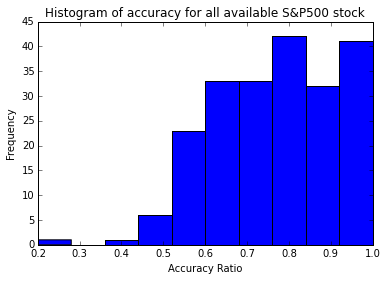

In [233]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.hist(indep_model_accuracy)
plt.title("Histogram of accuracy for all available S&P500 stock")
plt.xlabel("Accuracy Ratio")
plt.ylabel("Frequency")
plt.show()

0.466981132075


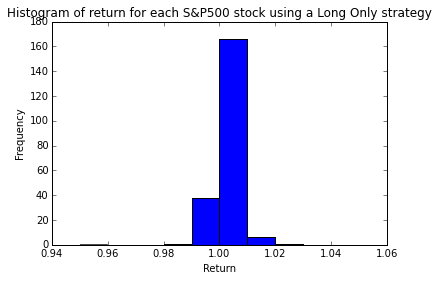

In [234]:
#count how many of the returns are actually larger than 1.00 over the time period and divide by length of vector
print sum(i > 1.0 for i in indep_model_return)*1.0/len(indep_model_return)

%matplotlib inline
import matplotlib.pyplot as plt
plt.hist(indep_model_return, bins=[0.95, 0.96, 0.97, 0.98, 0.99, 1.00, 1.01, 1.02, 1.03, 1.04, 1.05])
plt.title("Histogram of return for each S&P500 stock using a Long Only strategy")
plt.xlabel("Return")
plt.ylabel("Frequency")
plt.show()

0.674528301887


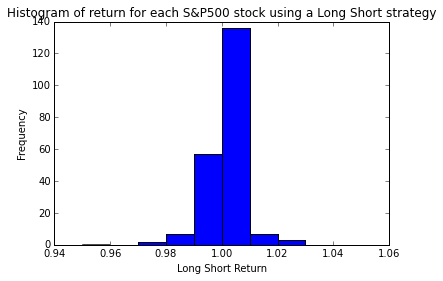

In [235]:
#count how many of the returns are actually larger than 1.00 over the time period and divide by length of vector
print sum(i > 1.0 for i in indep_model_ls_return)*1.0/len(indep_model_ls_return)

%matplotlib inline
import matplotlib.pyplot as plt
plt.hist(indep_model_ls_return, bins=[0.95, 0.96, 0.97, 0.98, 0.99, 1.00, 1.01, 1.02, 1.03, 1.04, 1.05])
plt.title("Histogram of return for each S&P500 stock using a Long Short strategy")
plt.xlabel("Long Short Return")
plt.ylabel("Frequency")
plt.show()

The results appear to be more superior under the TFIDF pair and the use of a neural network model. 

Looking at the results, it appears that the results are markedly better on the long and short strategy - even under various other vectorizers and machine learning algorithms. This is most likely due to the fact that we now take into account of tweets that generate negative news/headlines, and allow the portfolio strategy to take advantage of this and short sell the stock. Note that borrowing costs for short selling is ignored in this case, as is the same for commissions for long the stock. We believe costs such as this is minimal and can be neglected. 

Let us now attempt to look at the results if we were to specify a specific arbitrary variable (both on the long and short side) before an actual long or short position is taken. If the return does not move above this threshold, then no trade is taken. 

In [236]:
indep_model_accuracy = []
indep_model_return = []
indep_model_ls_return = []

return_var = 0.001

for i in range(0,300):
    ticker = snp500.loc[snp500.index[i], 'Ticker symbol']
    tweet_csv = ticker +'.csv'
    stock_csv = ticker +'.us.txt'
    tweets = pd.read_csv(tweet_csv, header=None)
    stocks = pd.read_csv(stock_csv)
    tweets.columns = ['timestamp', 'tweet']

    stocks['Timestamp'] = stocks.Date.astype(str).str.cat(stocks.Time.astype(str), sep=' ')

    #Convert to pandas date time format
    stocks['Timestamp'] = pd.to_datetime(stocks['Timestamp']) 
    tweets['timestamp'] = pd.to_datetime(tweets['timestamp']) 

    stocks['PreviousClose'] = stocks.Close.shift(1)
    stocks['Return'] = (stocks.Close/stocks.PreviousClose)-1
    
    tweets[['closest_timestamp', 'diff']] = tweets.timestamp.apply(
                                          find_closest_date, args=[stocks.Timestamp])

    combined = pd.merge(tweets, stocks, left_on=['closest_timestamp'], right_on=['Timestamp'])
    combined['Prediction_Class'] = np.where(combined['Return']>return_var, 'Up', 
                                            np.where(combined['Return']<-return_var , 'Down', 'Flat'))
    corpus_data_features = vectorizer.fit_transform(combined.tweet.tolist())
    corpus_data_features_nd = corpus_data_features.toarray()
    
    #Break out of loop if the stock does not have historical tweets. This will be flagged based on if the close price
    #is exactly the same as the last close price on the last tweet.
    if combined.Close.iloc[0]==combined.Close.iloc[len(combined)-1]:
        continue
    
    X_train, X_test, y_train, y_test  = train_test_split(
        corpus_data_features_nd[0:len(combined)], 
        combined.Prediction_Class,
        train_size=0.85)

    gnb_model = GaussianNB()
    gnb_model = gnb_model.fit(X=X_train, y=y_train)
    
    y_test_final = pd.Series.tolist(y_test)
    y_pred = gnb_model.predict(X_test)
    accuracy = accuracy_score(y_test_final, y_pred)
    
    agg_return = combined.Return[y_test.index]
    agg = pd.Series.tolist(agg_return)
    
    #Compute the actual stock return (regardless of time period) on a long only basis. i.e. we only capture return
    #if the stock is predicted to go up, and we assume an all-in all-out scenario, meaning positive returns are 
    #cumulative.
    stock_return = 1
    for i in (0, len(y_pred)-1):
        if y_pred[i] == "Up":
            stock_return = stock_return * (1 + agg[i])

    
    ls_stock_return = 1   
    for i in (0, len(y_pred)-1):
        if y_pred[i] == "Up":
            ls_stock_return = ls_stock_return * (1 + agg[i])
        if y_pred[i] == "Down":
            ls_stock_return = ls_stock_return * (1 - agg[i])
            
    indep_model_return.append(stock_return)
    indep_model_ls_return.append(ls_stock_return)
    
    indep_model_accuracy.append(accuracy)
    #print "Ticker: %s, Accuracy: %f" % (ticker, accuracy)
    

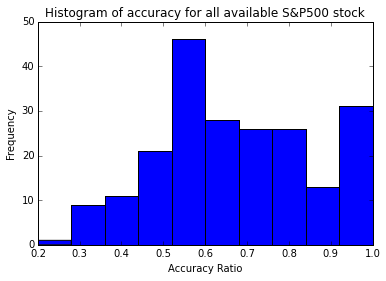

In [237]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.hist(indep_model_accuracy)
plt.title("Histogram of accuracy for all available S&P500 stock")
plt.xlabel("Accuracy Ratio")
plt.ylabel("Frequency")
plt.show()

0.25


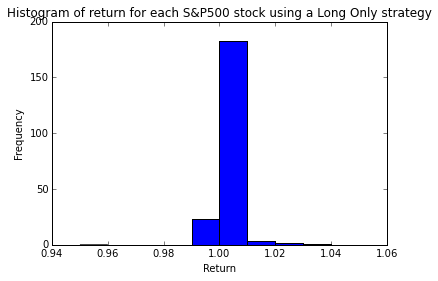

In [238]:
#count how many of the returns are actually larger than 1.00 over the time period and divide by length of vector
print sum(i > 1.0 for i in indep_model_return)*1.0/len(indep_model_return)

%matplotlib inline
import matplotlib.pyplot as plt
plt.hist(indep_model_return, bins=[0.95, 0.96, 0.97, 0.98, 0.99, 1.00, 1.01, 1.02, 1.03, 1.04, 1.05])
plt.title("Histogram of return for each S&P500 stock using a Long Only strategy")
plt.xlabel("Return")
plt.ylabel("Frequency")
plt.show()

0.438679245283


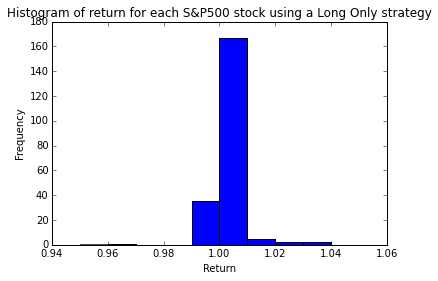

In [239]:
print sum(i > 1.0 for i in indep_model_ls_return)*1.0/len(indep_model_ls_return)

%matplotlib inline
import matplotlib.pyplot as plt
plt.hist(indep_model_ls_return, bins=[0.95, 0.96, 0.97, 0.98, 0.99, 1.00, 1.01, 1.02, 1.03, 1.04, 1.05])
plt.title("Histogram of return for each S&P500 stock using a Long Only strategy")
plt.xlabel("Return")
plt.ylabel("Frequency")
plt.show()

The results are less impressive compared to the baseline models. This is most likely due to the lack of data (i.e. specific news that causes spikes in stock prices tend not to occur frequently and may not be captured with the current set of data). Furthermore, the implementation of a specific arbitrary threshold might not apply consistently well across all stocks. Some stocks tend to react more or less depending on existing information and expectations. 

# Aggregate Model

We turn our attention to a more sophisticated model where it will encompass both language processing as well as other factors that drive the machine learning model. In this case, we explore using factors like the sector the stock is in, as well as the ticker itself, to train the model. Once the model is trained as a whole, the same long only strategy and long-short strategy is employed and we observe the various metrics to see whether this model performs better than our individual/independent stock models. 

In [225]:
agg_model_accuracy = []
agg_model_return = []
agg_model_ls_return = []

initial_features = np.empty((0,87), int)
initial_returns = np.empty((0,1))

from sklearn import preprocessing
import numpy as np

for i in range(0,300):
    ticker = snp500.loc[snp500.index[i], 'Ticker symbol']
    gics_sector = snp500.loc[snp500.index[i], 'GICS Sector']
    
    tweet_csv = ticker +'.csv'
    stock_csv = ticker +'.us.txt'
    tweets = pd.read_csv(tweet_csv, header=None)
    stocks = pd.read_csv(stock_csv)
    tweets.columns = ['timestamp', 'tweet']

    stocks['Timestamp'] = stocks.Date.astype(str).str.cat(stocks.Time.astype(str), sep=' ')

    #Convert to pandas date time format
    stocks['Timestamp'] = pd.to_datetime(stocks['Timestamp']) 
    tweets['timestamp'] = pd.to_datetime(tweets['timestamp']) 

    stocks['PreviousClose'] = stocks.Close.shift(1)
    stocks['Return'] = (stocks.Close/stocks.PreviousClose)-1
    
    tweets[['closest_timestamp', 'diff']] = tweets.timestamp.apply(
                                          find_closest_date, args=[stocks.Timestamp])

    combined = pd.merge(tweets, stocks, left_on=['closest_timestamp'], right_on=['Timestamp'])
    combined['Prediction_Class'] = np.where(combined['Return']>0, 'Up', 'Down')
    corpus_data_features = vectorizer.fit_transform(combined.tweet.tolist())
    corpus_data_features_nd = corpus_data_features.toarray()
    corpus_data_features_nd = pd.DataFrame(corpus_data_features_nd)
    #Break out of loop if the stock does not have historical tweets. This will be flagged based on if the close price
    #is exactly the same as the last close price on the last tweet.
    if combined.Close.iloc[0]==combined.Close.iloc[len(combined)-1]:
        continue
        
    #Add in the ticker symbol as well as the stock sector into the corpus_data_features_nd data frame
    corpus_data_features_nd['sector'] = gics_sector
    corpus_data_features_nd['ticker'] = ticker
    
    label = preprocessing.LabelEncoder() 
    ticker = preprocessing.LabelEncoder()
    corpus_data_features_nd.sector = label.fit_transform(corpus_data_features_nd.sector)
    corpus_data_features_nd.ticker = ticker.fit_transform(corpus_data_features_nd.ticker)
    
    combined_features = corpus_data_features_nd
    combined_features = np.vstack([initial_features, combined_features])
    combined_returns = pd.DataFrame(combined.Prediction_Class)
    combined_returns = np.vstack([initial_returns, combined_returns])

    X = pd.DataFrame(combined_features)
    y = pd.DataFrame(combined_returns)

X_train, X_test, y_train, y_test  = train_test_split(
    X, 
    y,
    train_size=0.85)

        
            
gnb_model = MLPClassifier()
gnb_model = gnb_model.fit(X=X_train, y=y_train)

y_pred = gnb_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print accuracy

agg_return = combined.Return[y_test.index]    
agg = pd.Series.tolist(agg_return)

stock_return = 1
for i in (0,len(agg_return)-1):
    if y_pred[i] == "Up":
        stock_return = stock_return * (1 + agg[i])

ls_stock_return = 1
for i in (0,len(agg_return)-1):
    if y_pred[i] == "Up":
        ls_stock_return = ls_stock_return * (1 + agg[i])
    if y_pred[i] == "Down":
        ls_stock_return = ls_stock_return * (1 - agg[i])

print ls_stock_return
print stock_return

0.8
1.00268071136
1.00027739251


# Conclusion

There are various and endless possibilities for exploration in the realm of using Twitter data, along with other market factors such as sector, in the constructs of portfolio strategy and management. 

# References

[1] Stock Prediction Using Twitter Sentiment Analysis by Anshul Mittal/Arpit Goel